# Compute the Mean Square Displacement (MSD)

In [1]:
import sys
import h5py
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
from msd.msd import compute_msd
from msd.plot import plot_msd, plot_coordinates
from notebookstyle import css_styling
%matplotlib inline
css_styling()

### Packages versions

In [2]:
print("Python version: {}".format(sys.version))
print("NumPy version: {}".format(np.__version__))
print("Scipy version: {}".format(sp.__version__))
print("h5py version: {}".format(h5py.__version__))
print("Matplotlib version: {}".format(mpl.__version__))

Python version: 3.6.2 |Intel Corporation| (default, Aug 15 2017, 17:12:56) 
[GCC 4.2.1 Compatible Apple LLVM 7.3.0 (clang-703.0.31)]
NumPy version: 1.13.1
Scipy version: 0.19.1
h5py version: 2.7.0
Matplotlib version: 2.0.2


## Read data

Simulation of a box of water (SPCE model)

In [3]:
file = 'Trajectories/spce300K_NVE_reduced.h5'

Explore the NetCDF file

In [4]:
with h5py.File(file, 'r') as f:
    ds = list(f.keys())
ds

['box_size', 'coordinates', 'natoms', 'time']

Extract the datasets

In [5]:
with h5py.File(file, 'r') as f:
    time = np.copy(f['time'])
    box_size = np.copy(f['box_size'])
    coordinates = np.copy(f['coordinates'])
    natoms = np.copy(f['natoms'])

In [6]:
print(time.shape, box_size.shape, coordinates.shape, natoms)

(10001,) (10001, 3) (10001, 768, 3) [768]


## Remove PBC

In [7]:
box_size = np.unique(box_size[:])

In [8]:
dx = coordinates[1:, :, :] - coordinates[:-1, :, :]

In [9]:
# correction - remove PBC
dx[dx>box_size/2] -= box_size
dx[dx<-box_size/2] += box_size

In [10]:
dx.cumsum(axis=0).shape

(10000, 768, 3)

In [11]:
# apply correction to the first coordinate (t0)
coord_nopbc = np.concatenate((np.array([coordinates[0, :, :]]), np.array(coordinates[0, :, :]) + dx.cumsum(axis=0)))

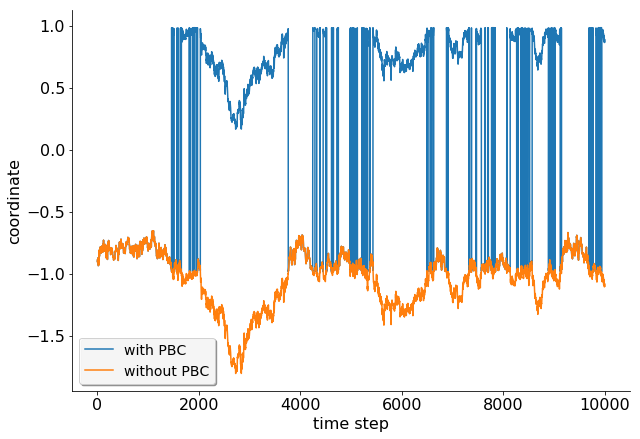

In [14]:
plot_coordinates(coordinates[:, 0, 0], coord_nopbc[:, 0, 0])

## Compute MSD for 2 atoms

In [17]:
msd_0 = compute_msd(coord_nopbc[:,0,:])

In [18]:
msd_9 = compute_msd(coord_nopbc[:,9,:])

Plot MSD

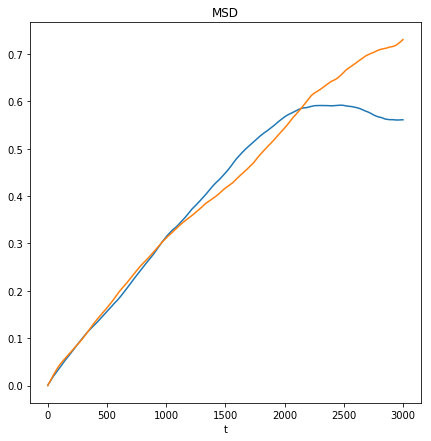

In [19]:
plot_msd([msd_0, msd_9], percentage=0.3)